In [1]:
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.impute import KNNImputer
from joblib import parallel_backend
from sklearn.model_selection import train_test_split, RepeatedKFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import PowerTransformer, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from hummingbird.ml import convert, load

C:\Users\Pabma\AppData\Local\Temp\ipykernel_26612\3539060139.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
ventas = pd.read_csv('ventas_dataframe.csv')
print(ventas)

        price_amount  makeid manufacturerprice        km  vehicleyear  \
0               9599      77             21625  152720.0         2018   
1               9990      22             21920  141485.0         2015   
2               9990      22             21920  141485.0         2015   
3               9900      84             14900  129000.0         2016   
4               8460      90             15060  117000.0         2018   
...              ...     ...               ...       ...          ...   
165749         11700      93                -   105000.0         2003   
165750         21300      10             30954  138600.0         2017   
165751       1050000      35            296454    9300.0         2015   
165752          3800      90                -   169000.0         2003   
165753          2300      77             18400  188000.0         2006   

        etiqueta_type_id  provinceid horsepower maxspeed acceleration  ...  \
0                      1          41        1

C:\Users\Pabma\AppData\Local\Temp\ipykernel_17756\1134956779.py:1: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  ventas = pd.read_csv('ventas_dataframe.csv')


In [5]:
conn = psycopg2.connect(dbname='TFM_Coches', user='postgres', password='9170', host='127.0.0.1', port='5432')

In [6]:
cursor = conn.cursor()
query = """
    select  v.price_amount, m.make, 
	ft.manufacturerprice, v.km, ft.vehicleyear, 
	em.etiqueta_type  , p.province, 
	ft.horsepower, ft.maxspeed, ft.acceleration, 
	com.combustible_type, b.body_type, t.transmision_type,
	ft.doors, ft.seatingcapacity, c.colores_type,   
	ft.dimensionsinmillimeterswidth, ft.dimensionsinmillimetersheight,
	ft.dimensionsinmillimeterslength, ft.weight, 
	ft.tankcapacityinliters, ft.trunkcapacityinliters, 
	ft.consumptionurban, ft.consumptionmixed, ft.consumptionextraurban,  
	ft.co2emissionsgramsperkm, ft.batteryvoltage, ft.batterykwh,
	ft.chargingtime, ft.chargingtimefast 
	from ventas v 
	inner join provincias p on v.provinceid = p.provinceid
	inner join fichas_tecnicas ft on v.ficha_id = ft.id
	inner join colores c on ft.vehiclecolorid = c.colores_type_id
	inner join transmision t on ft.transmissiontypeid = t.transmision_type_id 
	inner join bodytype b on ft.bodytypeid = b.body_type_id
	inner join combustible com on ft.fueltypeid = com.combustible_type_id 
	inner join etiqueta_medioambiental em on v.etiqueta_type_id = em.etiqueta_type_id
	inner join marcas m on ft.makeid = m.makeid ;
"""

# Ejecutar la consulta y guardar los resultados en un DataFrame de pandas
ventas_preview = pd.read_sql(query, conn)

# Mostrar los primeros registros del DataFrame
print(ventas_preview.head())

# Guardar el DataFrame como un archivo CSV
ventas_preview.to_csv('ventas_dataframe_preview.csv', index=False)

# Cerrar la conexión
cursor.close()
conn.close()

C:\Users\Pabma\AppData\Local\Temp\ipykernel_26612\1548596477.py:27: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  ventas_preview = pd.read_sql(query, conn)


  price_amount  makeid  modelid  versionid manufacturerprice      km  \
0         9599      77      314       4411             21625  152720   
1         9990      22      438      17597             21920  141485   
2         9990      22      438      17597             21920  141485   
3         9900      84      624      23187             14900  129000   
4         8460      90     1203         86             15060  117000   

  vehicleyear etiqueta_type  province horsepower  ... tankcapacityinliters  \
0        2018             C   Sevilla        110  ...                   48   
1        2015             C  Valencia         99  ...                   60   
2        2015             C    Murcia         99  ...                   60   
3        2016                  Madrid         75  ...                   45   
4        2018             C  Valencia         75  ...                   40   

  trunkcapacityinliters consumptionurban consumptionmixed  \
0                   370              

In [5]:
print(ventas_preview['price_amount'].dtype)

object


In [6]:
ventas_preview_filtered = ventas_preview[ventas_preview['combustible_type'] == 'gas_licuado_(GLP)'].head(20)
print(ventas_preview_filtered)

    price_amount     make manufacturerprice      km vehicleyear etiqueta_type  \
460         8990     OPEL             17450  102621        2019           ECO   
475         8940     OPEL             17450  122656        2019           ECO   
507         8990     OPEL             17450  115657        2019           ECO   
542         9950  CITROEN             16300   97423        2018                 
547         9999     FORD             18585  130000        2019           ECO   
586        11990     OPEL             17450   50000        2019           ECO   
603         6210  RENAULT             16175  228500        2017                 
633        10490     OPEL             17450   58369        2019           ECO   
635        10490     OPEL             17450  134672        2019                 
684        12990  RENAULT             16555   42993        2019           ECO   
696         9990     OPEL             17900   93400        2018           ECO   
713         8190     OPEL   

In [7]:
ventas_preview_filtered = ventas_preview[ventas_preview['combustible_type'] == 'gas_natural_(CNG)'].head(20)
print(ventas_preview_filtered)

     price_amount  make manufacturerprice      km vehicleyear etiqueta_type  \
483         12990  SEAT             20820   25000        2020           ECO   
581         14490  SEAT             25670   72000        2019           ECO   
727         12995  SEAT             25670   65000        2019           ECO   
851         14900  SEAT             23290   13400        2021           ECO   
1274        12900  SEAT             22140   48919        2020           ECO   
1361        13300  SEAT             18310   23429        2020           ECO   
1768        13990  SEAT             20820   24000        2020           ECO   
1981        14490  SEAT             22140   79000        2020           ECO   
2052        11900  SEAT             27700  126000        2020           ECO   
2134        13990  SEAT             23290   48297        2021           ECO   
2206        13900  SEAT             25670   63600        2019           ECO   
2453        11500  SEAT             23030  128000   

In [8]:
ventas_preview_filtered = ventas_preview[ventas_preview['combustible_type'] == 'hibrido_enchufable'].head(20)
print(ventas_preview_filtered)

      price_amount        make manufacturerprice      km vehicleyear  \
1318         32900         KIA             37325      12        2020   
4725         17000  VOLKSWAGEN             40250  160000        2017   
5289         16990  VOLKSWAGEN             46079  196000        2017   
7044         17500  VOLKSWAGEN             40250  229000        2017   
9448         18750  VOLKSWAGEN             39330  138561        2016   
9557         19900         BMW             53950  185045        2020   
11393        22499  VOLKSWAGEN             40250  119000        2017   
11558        23995  VOLKSWAGEN             40250   80000        2017   
12019        22890         BMW             53950   74473        2020   
12099        24490        AUDI             38700   87000        2017   
12108        24990  VOLKSWAGEN             40250   85000        2017   
12147        19999  VOLKSWAGEN             40250   98000        2017   
12172        22500         BMW             53950  140000        

In [9]:
filtered_data = ventas_preview_filtered[(ventas_preview_filtered['combustible_type'] == 'hibrido') & (ventas_preview_filtered['chargingtime'] != '-')].head(20)
print(filtered_data)

Empty DataFrame
Columns: [price_amount, make, manufacturerprice, km, vehicleyear, etiqueta_type, province, horsepower, maxspeed, acceleration, combustible_type, body_type, transmision_type, doors, seatingcapacity, colores_type, dimensionsinmillimeterswidth, dimensionsinmillimetersheight, dimensionsinmillimeterslength, weight, tankcapacityinliters, trunkcapacityinliters, consumptionurban, consumptionmixed, consumptionextraurban, co2emissionsgramsperkm, batteryvoltage, batterykwh, chargingtime, chargingtimefast]
Index: []

[0 rows x 30 columns]


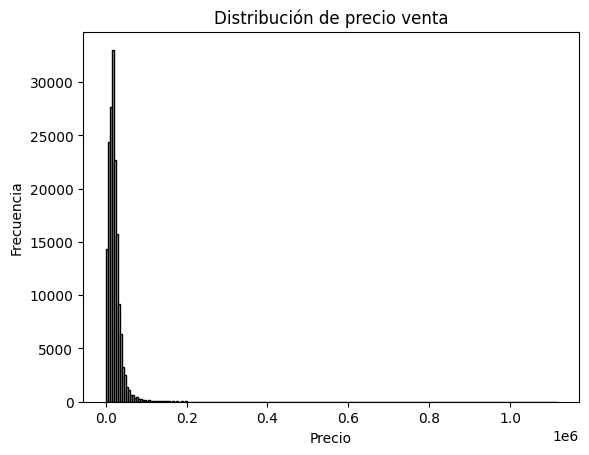

Coches mayores a 150000: 464


In [10]:
ventas_preview['price_amount'] = pd.to_numeric(ventas_preview['price_amount'], errors='coerce')
plt.hist(ventas_preview['price_amount'], bins=range(0, int(max(ventas_preview['price_amount'])) + 5000, 5000), color='skyblue', edgecolor='black')
# Añadir etiquetas y título
plt.title('Distribución de precio venta')
plt.xlabel('Precio')
plt.ylabel('Frecuencia')
# Mostrar el histograma
plt.show()
count_greater_than_150000 = ventas_preview[ventas_preview['price_amount'] > 150000]['price_amount'].count()
print('Coches mayores a 150000: ' + str(count_greater_than_150000))


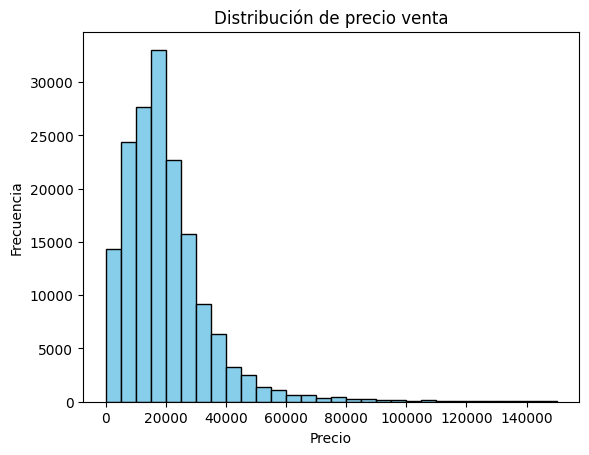

In [11]:
ventas_preview = ventas_preview[ventas_preview['price_amount'] <= 150000]

# Crear el histograma
plt.hist(ventas_preview['price_amount'], bins=range(0, int(max(ventas_preview['price_amount'])) + 5000, 5000), color='skyblue', edgecolor='black')

# Añadir etiquetas y título
plt.title('Distribución de precio venta')
plt.xlabel('Precio')
plt.ylabel('Frecuencia')

# Mostrar el histograma
plt.show()

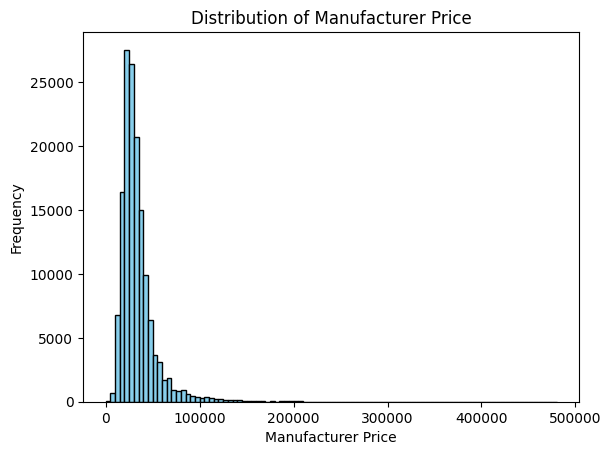

Manufacturer prices greater than 150000: 499


In [12]:
ventas_preview['manufacturerprice'] = pd.to_numeric(ventas_preview['manufacturerprice'], errors='coerce')
plt.hist(ventas_preview['manufacturerprice'], bins=range(0, int(max(ventas_preview['manufacturerprice'])) + 5000, 5000), color='skyblue', edgecolor='black')
plt.title('Distribution of Manufacturer Price')
plt.xlabel('Manufacturer Price')
plt.ylabel('Frequency')
plt.show()
count_greater_than_150000 = ventas_preview[ventas_preview['manufacturerprice'] > 150000]['manufacturerprice'].count()
print('Manufacturer prices greater than 150000: ' + str(count_greater_than_150000))

<Axes: xlabel='transmision_type'>

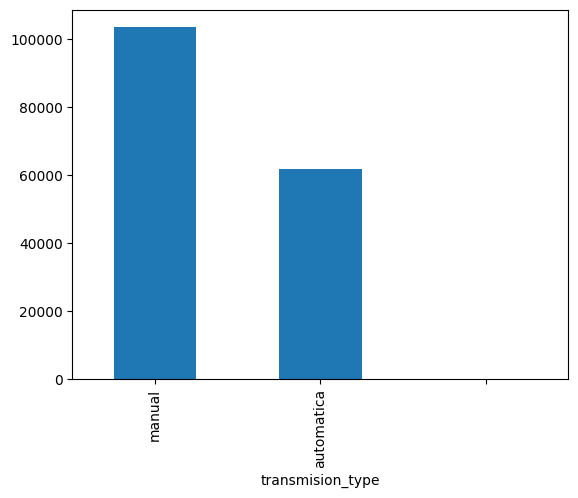

In [13]:
ventas_preview['transmision_type'].value_counts().plot(kind='bar')

<Axes: xlabel='etiqueta_type'>

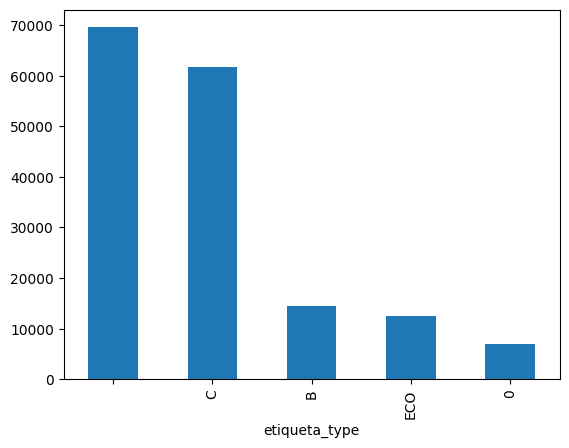

In [14]:
ventas_preview['etiqueta_type'].value_counts().plot(kind='bar')

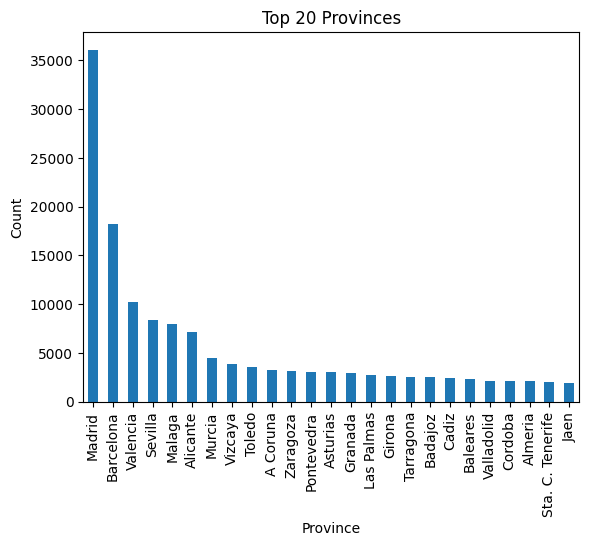

In [15]:
ventas_preview['province'].value_counts().head(25).plot(kind='bar')
plt.xlabel('Province')
plt.ylabel('Count')
plt.title('Top 20 Provinces')
plt.show()

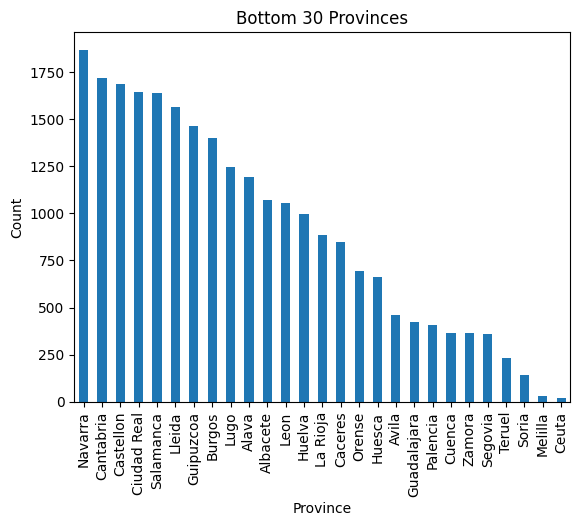

In [16]:
ventas_preview['province'].value_counts().tail(27).plot(kind='bar')
plt.xlabel('Province')
plt.ylabel('Count')
plt.title('Bottom 30 Provinces')
plt.show()

<Axes: xlabel='combustible_type'>

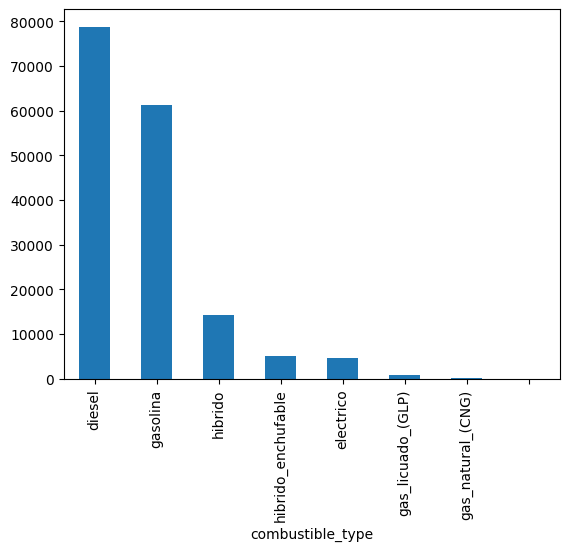

In [17]:
ventas_preview['combustible_type'].value_counts().plot(kind='bar')

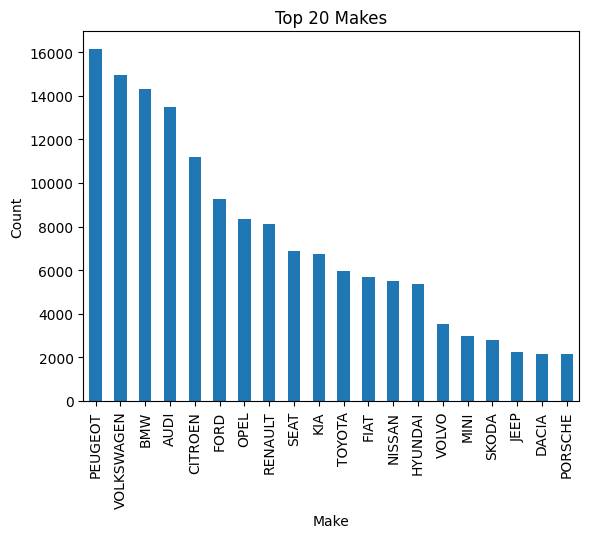

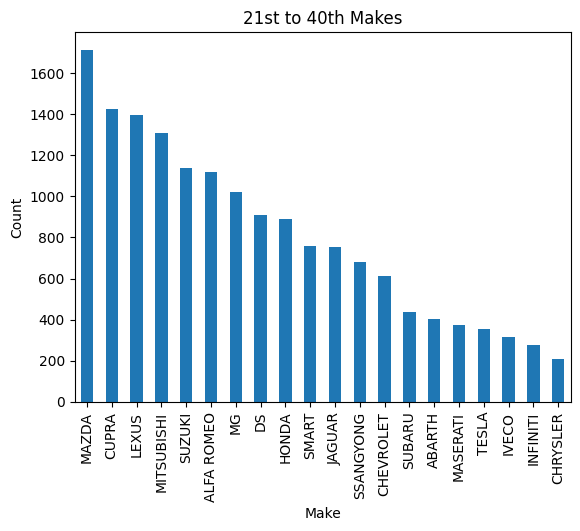

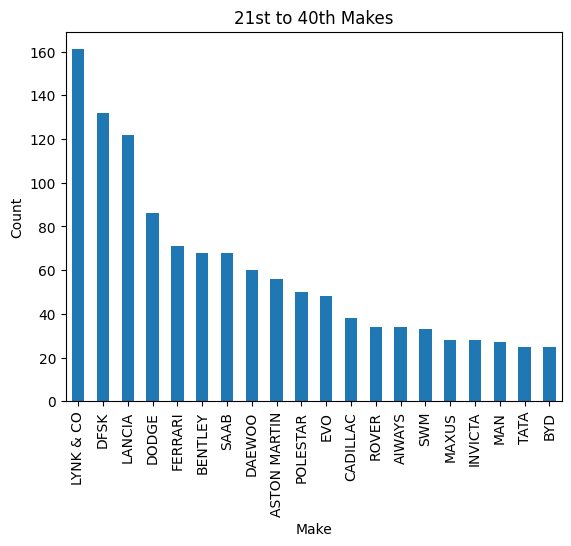

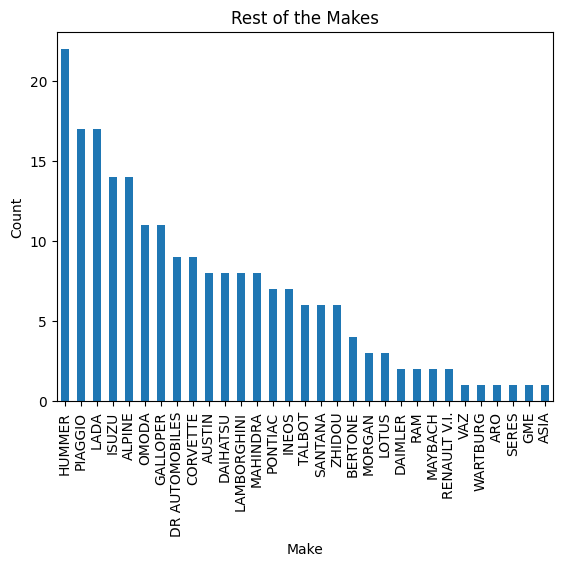

In [21]:
# Top 20 makes histogram
top_20_makes = ventas_preview['make'].value_counts().head(20)
top_20_makes.plot(kind='bar')
plt.xlabel('Make')
plt.ylabel('Count')
plt.title('Top 20 Makes')
plt.show()

# 21st to 40th makes histogram
makes_21_to_40 = ventas_preview['make'].value_counts().iloc[20:40]
makes_21_to_40.plot(kind='bar')
plt.xlabel('Make')
plt.ylabel('Count')
plt.title('21st to 40th Makes')
plt.show()

# 21st to 40th makes histogram
makes_40_to_60 = ventas_preview['make'].value_counts().iloc[40:60]
makes_40_to_60.plot(kind='bar')
plt.xlabel('Make')
plt.ylabel('Count')
plt.title('21st to 40th Makes')
plt.show()

# Rest of the makes histogram
rest_of_makes = ventas_preview['make'].value_counts().tail(-60)
rest_of_makes.plot(kind='bar')
plt.xlabel('Make')
plt.ylabel('Count')
plt.title('Rest of the Makes')
plt.show()


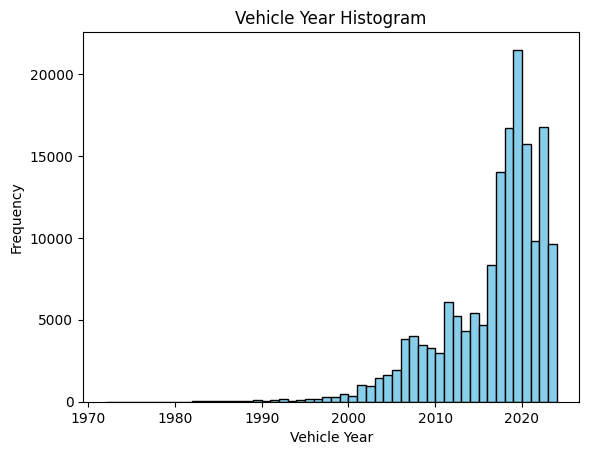

In [23]:
ventas_preview['vehicleyear'] = ventas_preview['vehicleyear'].astype(int)

plt.hist(ventas_preview['vehicleyear'], bins=range(min(ventas_preview['vehicleyear']), max(ventas_preview['vehicleyear']) + 1, 1), color='skyblue', edgecolor='black')
plt.title('Vehicle Year Histogram')
plt.xlabel('Vehicle Year')
plt.ylabel('Frequency')
plt.show()
